# Assignment 1 - POS tagging

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from data_input import DataInput
from text_vectorizer import TextVectorizer, TargetVectorizer

## 1. Build a dataset

### 1.1 Dataset preparation
For this experiment, the [Dependency Parsed Treebank](https://www.nltk.org/nltk_data/) dataset is used.

In [2]:
# download the dataset and split it into train, dev and test sets
dataset = DataInput(
        data_url="https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip",
        train_size=0.50,
        dev_size=0.25,
        dataset_folder=os.path.join(os.getcwd(), "dataset"),
        split_into_sentences=False,
        shuffle=False
    )

Train set size: 100
Dev set size: 50
Test set size: 49


Pre-processing is always an important step with which start. There are a lot of pre-processing steps that we can consider, but for this experiment the only pre-processing operation performed is:
- **to lower**, in part-of-speech tagging scenario casing of the input tokens is crucial to find the correspondent token in the embedding vocabulary

In [11]:
# do preprocessing for train, validation and test sets
dataset.preprocessing("train", to_lower=True)
dataset.preprocessing("dev", to_lower=True)
dataset.preprocessing("test", to_lower=True)

# separate inputs and targets
X_train, y_train = dataset.train
X_dev, y_dev = dataset.dev
X_test, y_test = dataset.test

### 1.2 Dataset analysis
Let's take a look at the dataset, to inspect the distribution of the POS tags

In [12]:
def get_occurences(data, ordered=False):
    """
    Get the occurences of each token in the data.

    Parameters
    ----------
    data : list of np arrays, representing the data to get the occurences from
    ordered : bool, if True, the occurences will be returned in descending order
    Returns
    -------
    occurences : dict, mapping each token to the number of occurences
    """
    tokens, counts = np.unique(np.concatenate(data), return_counts=True)
    occurences = dict(zip(tokens, counts))
    if ordered:
        occurences = dict(sorted(occurences.items(), key=lambda x: x[1], reverse=True))
    return occurences

# get the occurences of each POS tag in the three sets
train_tags_occ = get_occurences(y_train, ordered=True)
dev_tags_occ = get_occurences(y_dev)
test_tags_occ = get_occurences(y_test)

# build a matrix of the occurences of size (n_tags, 3)
tags_occ = np.array([[v, dev_tags_occ[k], test_tags_occ[k]] if k in dev_tags_occ and k in test_tags_occ else [v, dev_tags_occ[k], 0] if k in dev_tags_occ else [v, 0, test_tags_occ[k]] if k in test_tags_occ else [v, 0, 0] for k, v in train_tags_occ.items()])

[]

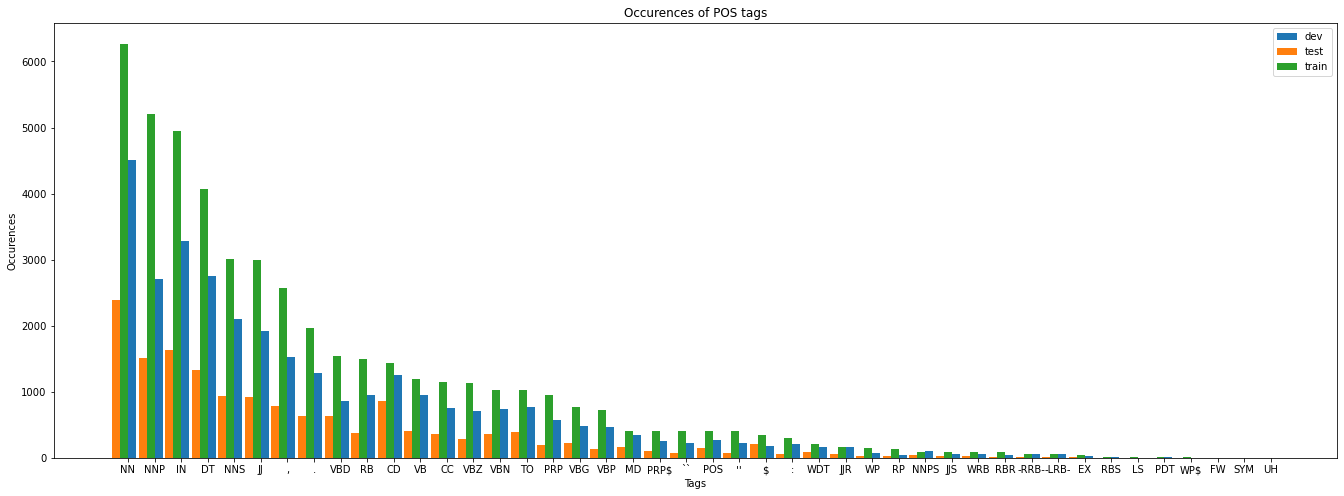

In [13]:
# plot bar chart of the occurences of each POS tag
fig, ax = plt.subplots(1, 1, figsize=(23, 8))
tags = list(train_tags_occ.keys())
ax.bar(tags, tags_occ[:, 1], width=0.3, align='edge', label='dev')
ax.bar(tags, tags_occ[:, 2], width=-0.6, align='edge', label='test')
ax.bar(tags, tags_occ[:, 0], width=-0.3, align='edge', label='train')
ax.set_xticks(tags)
ax.set_xlabel('Tags')
ax.set_ylabel('Occurences')
ax.set_title("Occurences of POS tags")
ax.legend()
plt.plot()

In [14]:
# analyze the difference between the presence of the POS tags in the train, dev and test sets
train_tags_not_dev = set(train_tags_occ.keys()) - set(dev_tags_occ.keys())
train_tags_not_test = set(train_tags_occ.keys()) - set(test_tags_occ.keys())
dev_tags_not_train = set(dev_tags_occ.keys()) - set(train_tags_occ.keys())
test_tags_not_train = set(test_tags_occ.keys()) - set(train_tags_occ.keys())

if(len(train_tags_not_dev) > 0):
    print("The following tags (from the train set) are not in the dev set:", train_tags_not_dev)
if(len(train_tags_not_test) > 0):
    print("The following tags (from the train set) are not in the test set:", train_tags_not_test)
if(len(dev_tags_not_train) > 0):
    print("The following tags (from the dev set) are not in the train set:", dev_tags_not_train)
if(len(test_tags_not_train) > 0):
    print("The following tags (from the test set) are not in the train set:", test_tags_not_train)

The following tags (from the train set) are not in the dev set: {'SYM'}
The following tags (from the train set) are not in the test set: {'SYM', 'LS', 'FW', 'UH'}


### 1.3 GloVe embeddings vectorization
The next step consists in downloading a pre-trained embedding model, namely GloVe. It is a techniques that tries to encoded global semantic properties based on the co-occurrence matrix.
Three different dimensional space versions are available: 50, 100, 200.

From the choosen embedding, a starting vocabulary is built.
Then this vocabulary is enriched with the embeddings computed for the OOV words.

In [15]:
# initialize the vectorizer for the input tokens to convert them to embedding vectors
# and build the vocabulary V1 from the glove embeddings
text_vectorizer = TextVectorizer(
    glove_url="http://nlp.stanford.edu/data/glove.6B.zip",
    max_tokens=20000,
    embedding_dim=50,
    embedding_folder=os.path.join(os.getcwd(), "glove")
)

# compute embeddings for terms (OOV1) in the training set that are out of vocabulary V1 and add them: V2=V1+OOV1
print("Parsing the training set...")
text_vectorizer.adapt(X_train)
# use the vocabulary V2 to convert the training set inputs into embedding vectors
X_train = text_vectorizer.transform(X_train)

# compute embeddings for terms (OOV2) in the validation set that are out of vocabulary V2 and add them: V3=V2+OOV2
print("\nParsing the validation set...")
text_vectorizer.adapt(X_dev)
# use the vocabulary V3 to convert the validation set inputs into embedding vectors
X_dev = text_vectorizer.transform(X_dev)

# compute embeddings for terms (OOV3) in the test set that are out of vocabulary V3 and add them: V4=V3+OOV3
print("\nParsing the test set...")
text_vectorizer.adapt(X_test)
# use the vocabulary V4 to convert the test set inputs into embedding vectors
X_test = text_vectorizer.transform(X_test)

Parsing the training set...
Generated embeddings for 359 OOV words.

Parsing the validation set...
Generated embeddings for 189 OOV words.

Parsing the test set...
Generated embeddings for 128 OOV words.


### 1.4 One-hot encoding of the targets
Each POS tag in each set is converted using the one-hot representation

In [8]:
# initialize the vectorizer for the target tags to convert them into one-hot representation
target_vectorizer = TargetVectorizer()

# adapt the target vectorizer with only the training set: we do not consider possible targets that are not seen in training set but they are in the dev/test set
target_vectorizer.adapt(y_train)  

# convert the targets into one-hot representation for each splitting set
y_train = target_vectorizer.transform(y_train)
y_dev = target_vectorizer.transform(y_dev)
y_test = target_vectorizer.transform(y_test)

## 2. Training

In [9]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam

class NeuralNetwork:
    def __init__(self, X_vocabulary, embedding_dim, one_hot_depth, sequence_length, embedding_matrix):
        embedding_layer = Embedding(
            len(X_vocabulary)+2, # Number of tokens in the vocabulary
            embedding_dim, # Dimensions of the embedding,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False
        )
        self.model = models.Sequential()
        self.model.add(layers.InputLayer(input_shape=(sequence_length,)))
        self.model.add(embedding_layer)
        self.model.add(layers.Bidirectional(layers.LSTM(99, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
        self.model.add(layers.TimeDistributed(layers.Dense(one_hot_depth)))
        self.model.add(layers.Activation('softmax'))
        self.model.compile(loss="categorical_crossentropy", optimizer=Adam(0.003),  metrics=["accuracy"])
        self.model.summary()


In [8]:
nn = NeuralNetwork(di.X_vocabulary, embedder.embedding_dim, di.one_hot_depth, di.sequence_length, embedding_matrix)
X_train, y_train = di.datasets[0]
history_bilstm = nn.model.fit(X_train, y_train, epochs=100, batch_size=12, validation_data=di.datasets[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          715600    
                                                                 
 bidirectional (Bidirectiona  (None, 200, 198)         158400    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 200, 39)          7761      
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, 200, 39)           0         
                                                                 
Total params: 881,761
Trainable params: 166,161
Non-trainable params: 715,600
_________________________________________________________________
Epoch 1/100
9/9 [===========================

## Hyperparameters tuning using Keras

In [ ]:
!pip install keras_tuner

In [ ]:
import keras_tuner as kt

In [ ]:
def baseline_model(units, rate, X_vocabulary, embedding_dim, one_hot_depth, sequence_length, embedding_matrix):
  embedding_layer = Embedding(
            len(X_vocabulary)+2, # Number of tokens in the vocabulary
            embedding_dim, # Dimensions of the embedding,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False
        )
  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(sequence_length,)))
  model.add(embedding_layer)
  model.add(layers.Bidirectional(layers.LSTM(units, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
  model.add(layers.TimeDistributed(layers.Dense(one_hot_depth, activation="softmax")))
  model.compile(loss="categorical_crossentropy", optimizer=Adam(rate),  metrics=["accuracy"])
  return model


def build_model(hp, X_vocabulary=di.X_vocabulary, embedding_dim=embedder.embedding_dim, one_hot_depth=di.one_hot_depth,
                sequence_length=di.sequence_length, embedding_matrix=embedding_matrix):
  lstm_units = hp.Int("units", min_value=50, max_value=600)
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model = baseline_model(lstm_units, learning_rate, X_vocabulary, embedding_dim, one_hot_depth, sequence_length, embedding_matrix)
  return model

build_model(kt.HyperParameters())


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=100,
    hyperband_iterations=2
)

tuner.search_space_summary()


In [ ]:
tuner.search(X_train, y_train, validation_data=di.datasets[1])

## First variation: BiGRU instead of BiLSTM

In [9]:
class GRUModel:
    def __init__(self, X_vocabulary, embedding_dim, one_hot_depth, sequence_length, embedding_matrix):
        embedding_layer = Embedding(
            len(X_vocabulary)+2, # Number of tokens in the vocabulary
            embedding_dim, # Dimensions of the embedding,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False
        )
        self.model = models.Sequential()
        self.model.add(layers.InputLayer(input_shape=(sequence_length,)))
        self.model.add(embedding_layer)
        self.model.add(layers.Bidirectional(layers.GRU(99, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
        self.model.add(layers.TimeDistributed(layers.Dense(one_hot_depth)))
        self.model.add(layers.Activation('softmax'))
        self.model.compile(loss="categorical_crossentropy", optimizer=Adam(0.003),  metrics=["accuracy"])
        self.model.summary()

In [11]:
nn = GRUModel(di.X_vocabulary, embedder.embedding_dim, di.one_hot_depth, di.sequence_length, embedding_matrix)
X_train, y_train = di.datasets[0]
history_bigru = nn.model.fit(X_train, y_train, epochs=100, batch_size=12, validation_data=di.datasets[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          715600    
                                                                 
 bidirectional_2 (Bidirectio  (None, 200, 198)         119394    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 200, 39)          7761      
 tributed)                                                       
                                                                 
 activation_2 (Activation)   (None, 200, 39)           0         
                                                                 
Total params: 842,755
Trainable params: 127,155
Non-trainable params: 715,600
_________________________________________________________________
Epoch 1/100
9/9 [=========================

## Second variation: two BiLSMT layers

In [12]:
class TwoLSTMModel:
    def __init__(self, X_vocabulary, embedding_dim, one_hot_depth, sequence_length, embedding_matrix):
        embedding_layer = Embedding(
            len(X_vocabulary)+2, # Number of tokens in the vocabulary
            embedding_dim, # Dimensions of the embedding,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False
        )
        self.model = models.Sequential()
        self.model.add(layers.InputLayer(input_shape=(sequence_length,)))
        self.model.add(embedding_layer)
        self.model.add(layers.Bidirectional(layers.LSTM(99, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
        self.model.add(layers.Bidirectional(layers.LSTM(99, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
        self.model.add(layers.TimeDistributed(layers.Dense(one_hot_depth)))
        self.model.add(layers.Activation('softmax'))
        self.model.compile(loss="categorical_crossentropy", optimizer=Adam(0.003),  metrics=["accuracy"])
        self.model.summary()

In [13]:
nn = TwoLSTMModel(di.X_vocabulary, embedder.embedding_dim, di.one_hot_depth, di.sequence_length, embedding_matrix)
X_train, y_train = di.datasets[0]
history_two_bilstm = nn.model.fit(X_train, y_train, epochs=100, batch_size=12, validation_data=di.datasets[1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 100)          715600    
                                                                 
 bidirectional_3 (Bidirectio  (None, 200, 198)         158400    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 200, 198)         236016    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 200, 39)          7761      
 tributed)                                                       
                                                                 
 activation_3 (Activation)   (None, 200, 39)           0         
                                                      

## Third variation: BiLSTM + two Dense layers

In [14]:
class TwoDenseModel:
    def __init__(self, X_vocabulary, embedding_dim, one_hot_depth, sequence_length, embedding_matrix):
        embedding_layer = Embedding(
            len(X_vocabulary)+2, # Number of tokens in the vocabulary
            embedding_dim, # Dimensions of the embedding,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False
        )
        self.model = models.Sequential()
        self.model.add(layers.InputLayer(input_shape=(sequence_length,)))
        self.model.add(embedding_layer)
        self.model.add(layers.Bidirectional(layers.LSTM(50, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
        self.model.add(layers.TimeDistributed(layers.Dense(60, activation="sigmoid")))
        self.model.add(layers.TimeDistributed(layers.Dense(one_hot_depth, activation="softmax")))
        self.model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001),  metrics=["accuracy"])
        self.model.summary()


In [15]:
nn = TwoDenseModel(di.X_vocabulary, embedder.embedding_dim, di.one_hot_depth, di.sequence_length, embedding_matrix)
X_train, y_train = di.datasets[0]
history_bilstm_two_dense = nn.model.fit(X_train, y_train, epochs=100, batch_size=12, validation_data=di.datasets[1])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 100)          715600    
                                                                 
 bidirectional_5 (Bidirectio  (None, 200, 100)         60400     
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 200, 60)          6060      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 200, 39)          2379      
 tributed)                                                       
                                                                 
Total params: 784,439
Trainable params: 68,839
Non-trainable params: 715,600
___________________________________________

### History of the training
Plot metrics evolution for each epoch during the training

In [16]:
import matplotlib.pyplot as plt
def plot_history(models_history, keys, model_names=[], labels=("epochs", "metrics"), figsize=(10,5), cmap='rainbow'):
    """
    Plot the history of the metrics in the history dictionary for each model.
        :param models_history: array of dictionary of the metric history for each model
        :param keys: list of keys of the metrics to plot
        :param model_names: list of names of the models
        :param labels: list of labels of the axes
        :param figsize: size of the figure
        :param cmap: color map used for the plot
    """

    # maps each model to a distinct RGB color
    cmap = plt.cm.get_cmap(cmap, len(models_history))

    
    fig = plt.figure(figsize=figsize)

    # for each model trained
    for i, history in enumerate(models_history):
        # take all pairs of training and val metrics
        for j in range(0, len(keys), 2):
            metric, val_metric = keys[j], keys[j+1]
            
            plt.plot(history[metric], label=f"{model_names[i]} {metric}", linestyle="solid", color=cmap(i))
            plt.plot(history[val_metric],  label=f"{model_names[i]} {val_metric}", linestyle="--",  color=cmap(i))
        
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    # Adding legend
    plt.legend(
          title ="Legend",
          loc ="upper left",
          bbox_to_anchor =(1.0, 0, 0.5, 1))
    plt.title("Training history")
    plt.grid(linestyle='--', linewidth=1)
    plt.show()

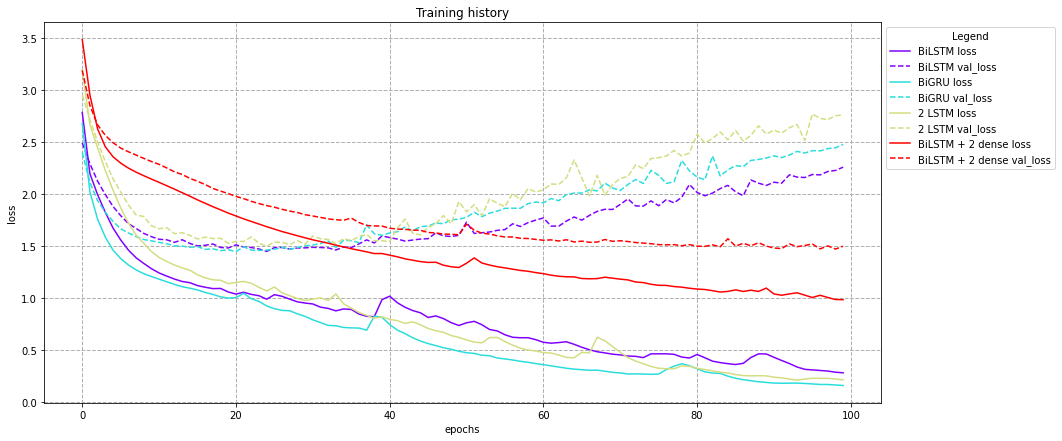

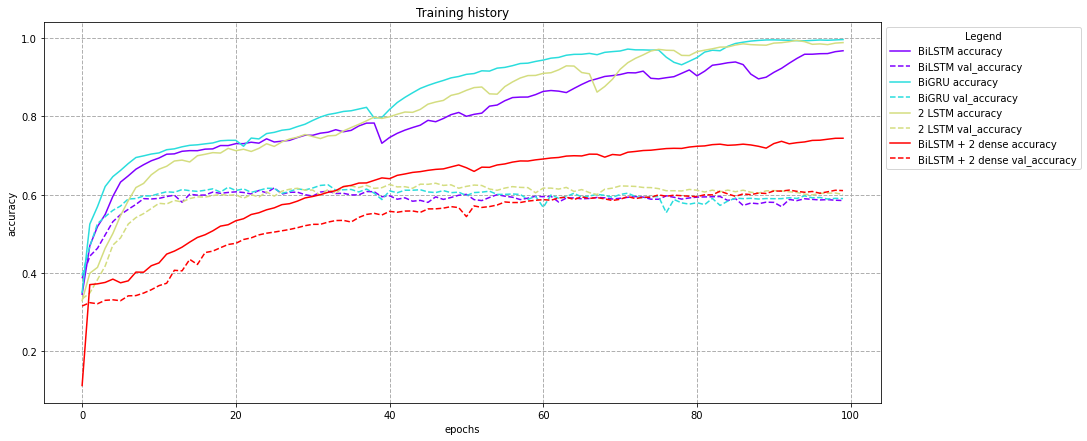

In [17]:
models_history = [history_bilstm.history, history_bigru.history, history_two_bilstm.history, history_bilstm_two_dense.history]
model_names = ["BiLSTM", "BiGRU", "2 LSTM", "BiLSTM + 2 dense"]
plot_history(models_history, keys=['loss', 'val_loss'], model_names=model_names, labels=("epochs", "loss"), figsize=(15,7))
plot_history(models_history, keys=['accuracy', 'val_accuracy'], model_names=model_names, labels=("epochs", "accuracy"), figsize=(15,7))